In [45]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [46]:
housing = sklearn.datasets.fetch_california_housing()


In [47]:
housing.data.shape

(20640, 8)

In [48]:
housing.target.shape

(20640,)

In [49]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [50]:
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

In [51]:
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [52]:
df.duplicated().sum()

np.int64(0)

In [53]:
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [54]:
X = df.drop(columns=['target'])
y = df['target'].values.reshape(-1,1)

In [55]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [56]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [57]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test


In [58]:
x_train.shape

torch.Size([14448, 8])

In [59]:
class CustomLinearRegression(nn.Module):
    def __init__(self, hidden_neurons, input_size=8, output_size=1):
        super(CustomLinearRegression, self).__init__()
        self.w1 = nn.Parameter(torch.randn(input_size, hidden_neurons, requires_grad=True))
        self.b1 = nn.Parameter(torch.randn(hidden_neurons, requires_grad=True))
        self.w2 = nn.Parameter(torch.randn(hidden_neurons, hidden_neurons, requires_grad=True))
        self.b2 = nn.Parameter(torch.randn(hidden_neurons, requires_grad=True))
        self.w3 = nn.Parameter(torch.randn(hidden_neurons, output_size, requires_grad=True))
        self.b3 = nn.Parameter(torch.randn(output_size, requires_grad=True))

    def forward(self, x):
        h1 = torch.relu(torch.matmul(x, self.w1) + self.b1)
        h2 = torch.relu(torch.matmul(h1, self.w2) + self.b2)
        h3 = torch.matmul(h2, self.w3) + self.b3
        return h3


In [60]:
def train_and_evaluate(model, train_data, val_data, params, n_epochs=100):
    batch_size = params['batch_size']
    learning_rate = params['lr']

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    loss_fn = params['loss_fn']
    optimizer = params['optimizer'](model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        # Training loop
        model.train()
        epoch_train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch)
                epoch_val_loss += loss_fn(y_pred, y_batch).item()

        val_losses.append(epoch_val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

In [61]:
def random_search(train_data, val_data, n_trials=10, n_epochs=100):
    param_space = {
        'lr': [0.01, 0.001, 0.0001],
        'batch_size': [64, 128, 256, 512],
        'hidden_neurons': [5, 10, 20],
        'optimizer': [torch.optim.SGD, torch.optim.Adam],
        'loss_fn': [nn.MSELoss()]
    }

    best_params, best_val_loss = None, float('inf')

    for trial in range(n_trials):
        params = {k: random.choice(v) for k, v in param_space.items()}
        print(f"Trial {trial+1}/{n_trials}, Testing params: {params}")

        model = CustomLinearRegression(hidden_neurons=params['hidden_neurons'])
        _, _, val_losses = train_and_evaluate(model, train_data, val_data, params, n_epochs)

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_params = params

    print(f"\nBest Hyperparameters: {best_params}\nBest Validation Loss: {best_val_loss:.4f}")
    return best_params

In [62]:
train_data = TensorDataset(x_train, y_train)

In [63]:
val_data = TensorDataset(x_val, y_val)

In [64]:
test_data = TensorDataset(x_test, y_test)

In [65]:
best_params = random_search(train_data, val_data, n_trials=10, n_epochs=100)

Trial 1/10, Testing params: {'lr': 0.0001, 'batch_size': 64, 'hidden_neurons': 10, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'loss_fn': MSELoss()}
Epoch 1/100 - Train Loss: 19.3027, Validation Loss: 6.8743
Epoch 2/100 - Train Loss: 6.0183, Validation Loss: 4.8783
Epoch 3/100 - Train Loss: 4.5882, Validation Loss: 3.9724
Epoch 4/100 - Train Loss: 3.8367, Validation Loss: 3.4389
Epoch 5/100 - Train Loss: 3.3818, Validation Loss: 3.1083
Epoch 6/100 - Train Loss: 3.0691, Validation Loss: 2.8617
Epoch 7/100 - Train Loss: 2.8399, Validation Loss: 2.6798
Epoch 8/100 - Train Loss: 2.6573, Validation Loss: 2.5194
Epoch 9/100 - Train Loss: 2.5056, Validation Loss: 2.3810
Epoch 10/100 - Train Loss: 2.3776, Validation Loss: 2.2655
Epoch 11/100 - Train Loss: 2.2650, Validation Loss: 2.1634
Epoch 12/100 - Train Loss: 2.1634, Validation Loss: 2.0735
Epoch 13/100 - Train Loss: 2.0731, Validation Loss: 1.9870
Epoch 14/100 - Train Loss: 1.9930, Validation Loss: 1.9114
Epoch 15/100 - Train Loss: 1.9187

In [66]:
best_params

{'lr': 0.01,
 'batch_size': 512,
 'hidden_neurons': 10,
 'optimizer': torch.optim.adam.Adam,
 'loss_fn': MSELoss()}

In [67]:
model = CustomLinearRegression(hidden_neurons=best_params['hidden_neurons'])

In [68]:
optimizer = best_params['optimizer'](model.parameters(), lr=best_params['lr'])

In [69]:
params = {'batch_size': best_params['batch_size'], 'lr': best_params['lr'], 'loss_fn': nn.MSELoss(), 'optimizer': best_params['optimizer']}

In [70]:
model, train_losses, val_losses = train_and_evaluate(model, train_data, val_data, params, n_epochs=100)

Epoch 1/100 - Train Loss: 224.4166, Validation Loss: 30.3282
Epoch 2/100 - Train Loss: 58.0401, Validation Loss: 5.2239
Epoch 3/100 - Train Loss: 32.3083, Validation Loss: 2.8144
Epoch 4/100 - Train Loss: 20.4002, Validation Loss: 2.1246
Epoch 5/100 - Train Loss: 10.9876, Validation Loss: 1.9227
Epoch 6/100 - Train Loss: 6.8846, Validation Loss: 1.7231
Epoch 7/100 - Train Loss: 4.3093, Validation Loss: 1.4881
Epoch 8/100 - Train Loss: 3.0901, Validation Loss: 1.3678
Epoch 9/100 - Train Loss: 2.3014, Validation Loss: 1.2560
Epoch 10/100 - Train Loss: 1.7991, Validation Loss: 1.1270
Epoch 11/100 - Train Loss: 1.4354, Validation Loss: 0.9927
Epoch 12/100 - Train Loss: 1.2814, Validation Loss: 0.9300
Epoch 13/100 - Train Loss: 1.0985, Validation Loss: 0.8876
Epoch 14/100 - Train Loss: 1.0058, Validation Loss: 0.8460
Epoch 15/100 - Train Loss: 0.9376, Validation Loss: 0.8245
Epoch 16/100 - Train Loss: 0.8934, Validation Loss: 0.7884
Epoch 17/100 - Train Loss: 0.8543, Validation Loss: 0.7622

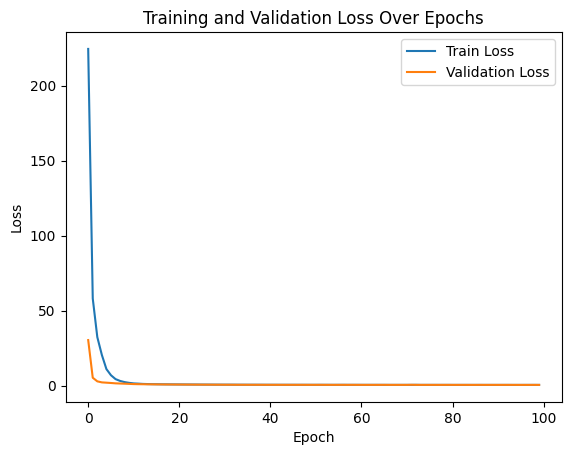

In [71]:
plt.plot(np.arange(100), train_losses, label='Train Loss')
plt.plot(np.arange(100), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

In [72]:
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)
    test_loss = params['loss_fn'](y_test_pred, y_test).item()

print(f"Final Test Loss: {test_loss:.4f}")

Final Test Loss: 0.4378


In [73]:
y_test_pred_numpy = y_test_pred.numpy()
y_test_numpy = y_test.numpy()

mse = mean_squared_error(y_test_numpy, y_test_pred_numpy)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test_numpy, y_test_pred_numpy)
r2 = r2_score(y_test_numpy, y_test_pred_numpy)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

MSE: 0.4378, RMSE: 0.6617, MAE: 0.4657, R²: 0.6689


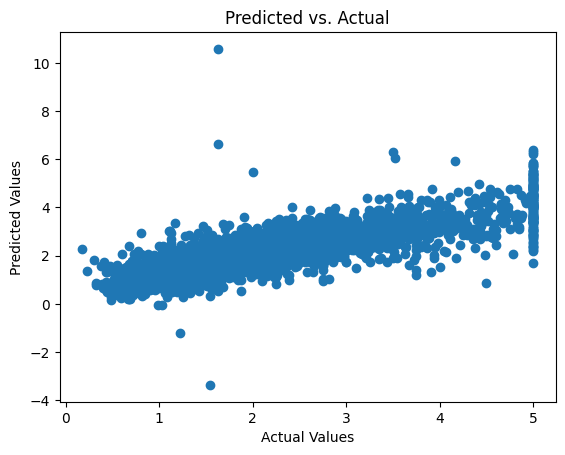

In [74]:
# Predicted vs. Actual
plt.scatter(y_test_numpy, y_test_pred_numpy)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual")
plt.show()

In [75]:
torch.save(model.state_dict(), "best_model.pth")